In [179]:
import pandas as pd
import chess.pgn
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from scipy import stats
import statsmodels.api as sm
import pylab as pl

All the documentation needed to use this library is here: https://readthedocs.org/projects/python-chess/downloads/pdf/latest/

### Only a batch of the 2.2 million games were visualized, 7000 games were taken from the file specified in the cell below

In [27]:
pgn = open("KingBase2019-A80-A99.pgn")
games = [] 
i = 0
while i < 7000:
    game = chess.pgn.read_game(pgn)
    games.append(game)
    i += 1

In [78]:
games

[<Game at 0x7f0af6ed1e80 ('Srihari, L R' vs. 'Sandipan, Chanda', '2018.12.31')>,
 <Game at 0x7f0b1e53a630 ('Ravi, Teja S' vs. 'Thipsay, Bagyashree Sathe', '2018.12.31')>,
 <Game at 0x7f0aff27c390 ('Rohith, Krishna S' vs. 'Yeoh, Li Tian', '2018.12.31')>,
 <Game at 0x7f0aff2fcb00 ('Liu, Yi' vs. 'Ikeda, Junta', '2018.12.31')>,
 <Game at 0x7f0af6fafdd8 ('Deshpande, Ani' vs. 'Kulkarni, Vikramaditya', '2018.12.31')>,
 <Game at 0x7f0b1088e630 ('Leenhouts, Koen' vs. 'Stefansson, Vignir Vatnar', '2018.12.31')>,
 <Game at 0x7f0afe8beac8 ('Sokolov, Andrei2' vs. 'Gareev, Timur', '2018.12.30')>,
 <Game at 0x7f0afe8b1278 ('Vo, Thi Kim Phung' vs. 'Nomin-Erdene, Davaademberel', '2018.12.30')>,
 <Game at 0x7f0afe888860 ('Chkhaidze, Nikoloz' vs. 'Antal, Gergely', '2018.12.30')>,
 <Game at 0x7f0afe8ae710 ('Sjugirov, Sanan' vs. 'Amin, Bassem', '2018.12.30')>,
 <Game at 0x7f0afe89d588 ('Naumkin, Igor' vs. 'Henderson de La Fuente, Lance', '2018.12.30')>,
 <Game at 0x7f0afe8ae518 ('Sanikidze, Tornike' vs. 'P

## Wins grouped by Team & Draws

We will extract the Result string from the games list into the results list. We will then count the no of victories per each team and the no of draws

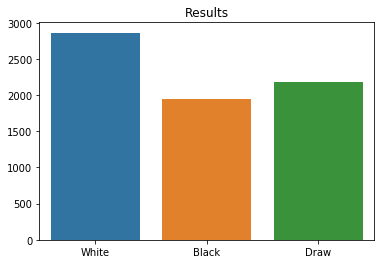

In [28]:
def number_wins(games):
    results = []
    for game in games:
        result = game.headers["Result"]
        results.append(result)
    return results

results = number_wins(games)
white_wins = results.count('1-0')
black_wins = results.count('0-1')
draws = results.count('1/2-1/2')

sns.barplot(['White', 'Black', 'Draw'], [white_wins, black_wins, draws])
plt.title('Results')
plt.show()

## Distribution of number of moves

In some cases, chess games may last to see over 200 moves.
https://www.chess.com/article/view/the-4-longest-chess-games-in-history

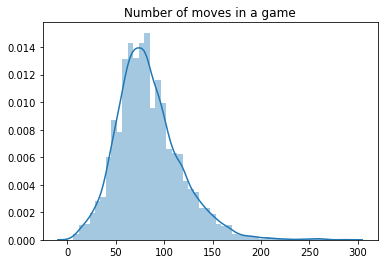

In [29]:
def number_moves(game):
    i = 0
    for move in game.mainline_moves():
        i += 1
    return i

def number_moves_dist(games):
    n_moves = []
    for game in games:
        n_moves.append(number_moves(game))
    return n_moves

sns.distplot(number_moves_dist(games))
plt.title('Number of moves in a game')
plt.show()

It seems for the most part, an average chess game lasts between 50-100 moves

## Top captures

Number of captures by each piece type, making use of the 'is_capture' function as well as other functions from the library. There capturers are split as follows:

P=pawn, N=knight, B=Bishop, R=Rook, Q=Queen, K=King

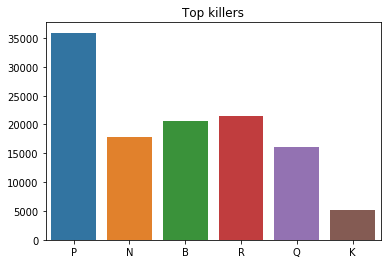

In [32]:
def top_killers(game):
    killers = {'P': 0, 'N': 0, 'B': 0, 'R': 0, 'Q': 0, 'K': 0}
    board = game.board()
    for move in game.mainline_moves():
        if board.is_capture(move):
            from1 = chess.SQUARES[move.from_square]
            symb = board.piece_at(from1).symbol().upper()
            killers[symb] += 1
        board.push(move)
    return killers

def top_killers_total(games):
    killers_total = {'P': 0, 'N': 0, 'B': 0, 'R': 0, 'Q': 0, 'K': 0}
    for game in games:
        killers_game = top_killers(game)
        for piece in killers_total.keys():
            killers_total[piece] += killers_game[piece]
    return killers_total

top_killers_dict = top_killers_total(games)
sns.barplot(list(top_killers_dict.keys()), list(top_killers_dict.values()))
plt.title('Top killers')
plt.show()

Pawn is a bad man

## Top captures piece by piece

Number of captures of a specific piece by a specific piece.


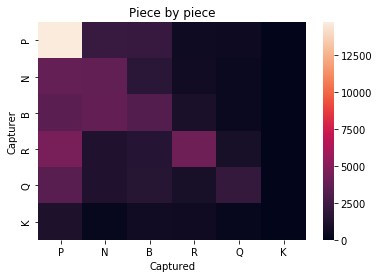

In [43]:
def top_killers_pieces(game):
    killers = {'P': {}, 'N': {}, 'B': {}, 'R': {}, 'Q': {}, 'K': {}} # for obtaining capturers symbol
    killers_sub = {'P': 0, 'N': 0, 'B': 0, 'R': 0, 'Q': 0, 'K': 0} # for obtaining no of kills by specific capturer
    for piece in killers.keys():
        killers[piece] = dict(killers_sub)
        # P: p=0 , n=0 , ....
        # dictionary lists are pretty cool
        
    board = game.board() #init game board
    for move in game.mainline_moves(): #iterate through moves
        if board.is_capture(move): #checks if the move is a capture.
            try:
                from1= chess.SQUARES[move.from_square] #start position before capture
                symb_from = board.piece_at(from1).symbol().upper() #taking symbol of capturer
                to1 = chess.SQUARES[move.to_square] #move to capturee position
                symb_to = board.piece_at(to1).symbol().upper()# take capturee symbol
                killers[symb_from][symb_to] += 1 #find the count in dict according to keys and increment by 1
                # in the dict of capturer, the no of captures of the capturee symbol
                # example if a pawn took a pawn the dict will look like this
                # 'P': {'P':1, 'N': 0, 'B': 0, 'R': 0, 'Q': 0, 'K': 0}
                # spent a lot of time on this
            except:
                pass #do nothing
        board.push(move)# move the piece to position and keep checking for next capturer
    return killers

def top_killers_pieces_total(games):
    killers_total = {'P': {}, 'N': {}, 'B': {}, 'R': {}, 'Q': {}, 'K': {}}
    killers_sub = {'P': 0, 'N': 0, 'B': 0, 'R': 0, 'Q': 0, 'K': 0}
    for piece in killers_total.keys():
        killers_total[piece] = dict(killers_sub) # creating dict lists for each capturer
        
    for game in games: #iterate through games
        killers_game = top_killers_pieces(game) # this will find the capturer and the no of kills for each capturee
        for piece in killers_total.keys():
            for piece_2 in killers_total[piece].keys(): #capturee keys
                killers_total[piece][piece_2] += killers_game[piece][piece_2]
    return killers_total

top_killers_pieces_total_dict = top_killers_pieces_total(games)
data = []
for piece in top_killers_pieces_total_dict.keys():
    data.append(list(top_killers_pieces_total_dict[piece].values()))
    
sns.heatmap(data, xticklabels=top_killers_pieces_total_dict.keys(), yticklabels=top_killers_pieces_total_dict.keys())
plt.title('Piece by piece')
plt.xlabel('Captured')
plt.ylabel('Capturer')
plt.show()

Pawns mostly capture pawns, knights rarely capture knights, etc

## Number of Castling made by 2 parties 

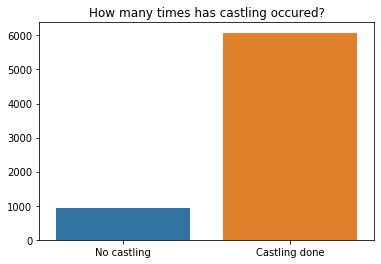

In [35]:
def castling(game):
    board = game.board()
    castling_times = 0
    for move in game.mainline_moves():
        if board.is_castling(move):
            castling_times += 1
        if castling_times == 2:
            break
        board.push(move)
    return True if castling_times == 2 else False

def castling_total(games):
    no_castling_total = 0
    castling_total = 0
    for game in games:
        castling_game = castling(game)
        if castling_game:
            castling_total += 1
        else:
            no_castling_total += 1
    return no_castling_total, castling_total

no_castling_total, castling_total = castling_total(games)
sns.barplot(['No castling', 'Castling done'], [no_castling_total, castling_total])
plt.title('How many times has castling occured?')
plt.show()

It seems that castling is very common in chess

## Most popular starting move

The most popular starting move is d2 -> d4.

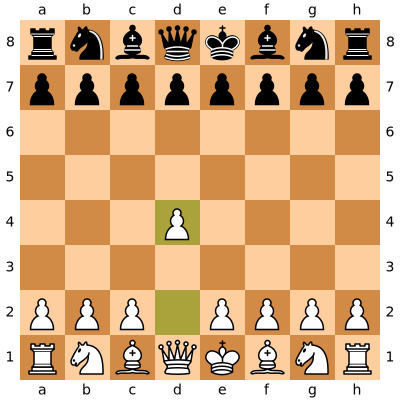

In [24]:
def first_move(game):
    board = game.board()
    for move in game.mainline_moves():
        return move.uci()
    
def first_move_total(games):
    all_moves = []
    for game in games:
        move = first_move(game)
        all_moves.append(move)
    return all_moves

def most_common(lst):
    return max(set(lst), key=lst.count)

moves = first_move_total(games)
board = chess.Board()
move_uci = chess.Move.from_uci(most_common(moves))
board.push(move_uci)
board

## Most active part of the board

Number of moves made to a specific square. Which square saw the most action?

In [36]:
pgn = open("KingBase2019-A80-A99.pgn")
games = [] 
i = 0
while i < 4000: # had to notch it down to 4000 otherwise the heatmap would not show
    game = chess.pgn.read_game(pgn)
    games.append(game)
    i += 1

In [37]:
def move_squares(game):
    board = game.board()
    results = {}
    for letter in 'abcdefgh':
        for number in range(1, 9):
            results[letter + str(number)] = 0
            
    for move in game.mainline_moves():
        if not board.is_castling(move):
            to_ = move.uci()[2:4]
            results[to_] += 1
            
    return results

def move_squares_total(games):
    results = {}
    for letter in 'abcdefgh':
        for number in range(1, 9):
            results[letter + str(number)] = 0
            
    for game in games:
        results_game = move_squares(game)
        for square in results.keys():
            results[square] += results_game[square]
            
    return results

move_squares_dict = move_squares_total(games)
data_ = []
text_ = []
for number in range(1, 9):
    results = []
    text_inter = []
    for letter in 'abcdefgh':
        results.append(move_squares_dict[letter + str(number)])
        text_inter.append(letter + str(number) + f' - {move_squares_dict[letter + str(number)]}')
    data_.append(results)
    text_.append(text_inter)

fig = go.Figure(data=go.Heatmap(
                    hoverinfo='text',
                    text=text_,
                    z=data_,
                    x='a b c d e f g h'.split(' '),
                    y=[i for i in range(1, 9)]
))
fig.show()

### e4 seems to be the most sociable

In [44]:
pgn = open("KingBase2019-A80-A99.pgn")
games = [] 
i = 0
while i < 7000:
    game = chess.pgn.read_game(pgn)
    games.append(game)
    i += 1

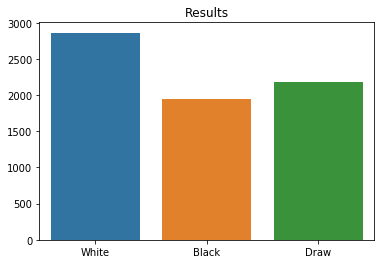

In [45]:
def number_wins(games):
    results = []
    for game in games:
        result = game.headers["Result"]
        results.append(result)
    return results

results = number_wins(games)
white_wins = results.count('1-0')
black_wins = results.count('0-1')
draws = results.count('1/2-1/2')

sns.barplot(['White', 'Black', 'Draw'], [white_wins, black_wins, draws])
plt.title('Results')
plt.show()

# Statistical Test

I'm going to extract the number of moves everytime a white team won in a unique list, same for black team and for draws

In [186]:
games_white_wins = []
games_black_wins = []
games_draws = []

for game in games:
     if game.headers["Result"] == "1-0":
            games_white_wins.append(game)
for game2 in games:
     if game2.headers["Result"] == "0-1":
            games_black_wins.append(game2)

for game3 in games:
     if game3.headers["Result"] == "1/2-1/2":
            games_draws.append(game3)
            
white_win_moves = []
black_win_moves = []
draws_moves = []

for game in games_white_wins:
    i = 0
    for move in game.mainline_moves():
        i += 1
    white_win_moves.append(i)
    
for game2 in games_black_wins:
    j = 0
    for move2 in game2.mainline_moves():
        j += 1
    black_win_moves.append(j)
    
for game3 in games_draws:
    k = 0
    for move3 in game3.mainline_moves():
        k += 1
    draws_moves.append(k)

In [260]:
sum = 0
for i in white_win_moves:
    sum += i
    
sum2 = 0
for i in black_win_moves:
    sum2 += i

print("Mean moves for a white win:",sum/len(white_win_moves))

print("Mean moves for a black win:",sum2/len(black_win_moves))

Mean moves for a white win: 83.4804469273743
Mean moves for a black win: 86.97483307652799


It seems that the mean for a black win and a white win are very similar. Does the distribution exhibit normality?

In [262]:
import pandas as pd
import numpy as np

df1=pd.DataFrame(black_win_moves,columns=['Moves'])
df1['Team'] = 'Black'


df2=pd.DataFrame(white_win_moves,columns=['Moves'])
df2['Team'] = 'White'

df = pd.concat([df1, df2], ignore_index=True, sort =False)
df.set_index('Team')

,Moves
Team,
Black,82
Black,108
Black,52
Black,92
Black,64
Black,66
Black,150
Black,74
Black,110


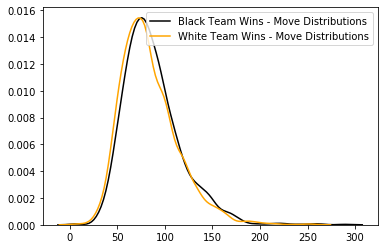

In [263]:
sns.kdeplot(df1['Moves'], color="black", label="Black Team Wins - Move Distributions")
sns.kdeplot(df2['Moves'], color="orange", label="White Team Wins - Move Distributions")

Very similar distributions as seen by the kernel density plots

In [264]:
stat, p = stats.normaltest(df1.Moves)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

print('-----------------------------------')
stat, p = stats.normaltest(df2.Moves)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=486.251, p=0.000
Data does not look Gaussian (reject H0)
-----------------------------------
Statistics=530.431, p=0.000
Data does not look Gaussian (reject H0)


We will need to apply a non-parametric test, given the data does not exhibit normality

In [265]:
df4 = np.random.permutation(df['Moves'].values) # 
df['Shuffle'] = df4
df = df.drop(['Moves'],axis=1)

In [266]:
df

,Team,Shuffle
0,Black,63
1,Black,49
2,Black,131
3,Black,72
4,Black,66
5,Black,95
6,Black,58
7,Black,79
8,Black,33
9,Black,112


Given our moves column is of a quantitative continuous type. We will apply Mann Whitney Test

Assumptions of the Mann-Whitney test:

- random samples from populations
- independence within samples and mutual independence between samples
- measurement scale is either ordinal or continuous

Ho: There will be no statistically significant differences on [ordinal dependent variable name here] by [independent variable here].

Ha: There will be statistically significant differences on [ordinal dependent variable name here] by [independent variable here].

In [257]:

df_random = df.sample(n=1000)
df_random = df.groupby('Team')

df_black_shuffle = df_random.get_group('Black') 
df_white_shuffle = df_random.get_group('White')

In [259]:
df_white_shuffle

,Team,Shuffle
1947,White,71
1948,White,72
1949,White,82
1950,White,57
1951,White,70
1952,White,47
1953,White,79
1954,White,63
1955,White,140
1956,White,57


In [269]:
fail_rej = 0
reject = 0

for i in range(1000):  # simulate 1000 times
    df_random = np.random.permutation(df['Shuffle'].values) # shuffle price values
    df.drop(['Shuffle'], axis=1) # 
    df['Shuffle'] = df4
    df_shuffle = df.sample(n=1000) #taking a 1000 random samples for the shuffle list
    df_shuffle = df.groupby('Team')
    df_white_shuffle = df_shuffle.get_group('White') 
    df_black_shuffle = df_shuffle.get_group('Black')
    a = df_white_shuffle['Shuffle']
    b = df_black_shuffle['Shuffle']

    stat, p = stats.mannwhitneyu(a, b)
    alpha = 0.05
    if p > alpha:
        fail_rej += 1
    else:
        reject += 1
print('-----------------------------')
print("Same distribution (fail to reject H0) = %d" % fail_rej)
print("Different distribution (reject H0) =  %d" % reject)






-----------------------------
Same distribution (fail to reject H0) = 0
Different distribution (reject H0) =  1000
